<h1 style='text-align: center;'> 
Blackpropagation in Neural Networks
</h1>

`Narváez J.`
<p style='text-align: justify;'> 

<p style='text-align: justify;'>  
In this notebook, we will introduce a method for updating weights and biases in a multilayer neural network. We will implement this algorithm to predict a two-dimensional function.
</p>

# Backpropagation

## Notation and Assumptions

<p style='text-align: justify;'>
In the Perceptron notebook, we have computed the gradient of the cost function for a single neuron. Now, we want to generalize this process to a multilayer neural network, i.e. find a way to compute $\nabla _ w C(w)$.
</p>
    
With this goal in mind, firstly, let's generalize our notation to an n-layer NN:

* $w^l_{jk}$ represents the weight from the $k$th-neuron in $(l-1)$th-layer to the $j$th-neuron of $l$th-layer. 


* $a^l_j$ is the input value for $j$th neuron in $l$th layer, that is:
<div id="a_jl"></div>
$$
\begin{equation}\label{a_jl} \tag{1}
a^l_j = F\left(z_j^l\right)=F\left(\sum_kw^l_{jk}a^{l-1}_k\right),
\end{equation}
$$
where $F$ is the activation function.
     
Next, we need to make two assumptions about the cost function:

* $C(w) = \frac{1}{n}\sum_k C_k(w)$, that is, $C$ could be considered as an average over individual training examples.


* $C = C(a^L_j)$ where $L$ is the last layer. It implicates that the cost functions can be written as a function of the outputs.

<p style='text-align: justify;'> 
For instance, let's see the <b>mean squared error (MSE)</b>, defined by  
</p>

<div id="CostF"></div>

$$
\begin{equation} \label{CostF} \tag{2}
  C = \frac{1}{2}\sum_{j}\parallel y_j - a^L_j\parallel ^2, \hspace{0.5 cm}\text{for a single example}.
\end{equation}
$$

where $y_j$ are the target values.

## Gradient Descent

We want to calculate the gradient $\nabla_w C$, but for this purpose, we first introduce the intermediate quantity $\delta_j^l$, which represents the error of the $j$th-neuron in $l$th-layer. It is defined by

<div id="delta"></div>

$$
\begin{equation}\label{delta}\tag{3}
    \delta_j^l = \frac{\partial C}{\partial z_j^l}.
\end{equation}
$$

- The error in the output layer:

$$
\begin{equation}
    \delta_j^L = \frac{\partial C}{\partial z_j^L} = \frac{\partial C}{\partial a_j^L}F^\prime(z_j^L),
\end{equation}
$$

therefore,

<div id="OutpulError"></div>

$$
\begin{equation}\label{OutpulError}\tag{4}
    \delta_j^L = \left(a_j^L-y_j\right)F^\prime(z_j^L).
\end{equation}
$$

- The error $\sigma_j^l$

$$
\begin{align}
    \delta_j^l &= \frac{\partial C}{\partial z_j^l}\\
    &= \sum_m \frac{\partial C}{\partial z_m^{l+1}}\frac{\partial z_m^{l+1}}{\partial z_j^{l}}\\
    &= \sum_m \delta_m^{l+1}\frac{\partial z_m^{l+1}}{\partial z_j^{l}}\\
    &=\sum_m\delta_m^{l+1}\frac{\partial}{\partial z_j^{l}}\left(\sum_kw_{mk}^{l+1}a^{l}_k\right)\\
    &=\sum_m\delta_m^{l+1}\frac{\partial}{\partial z_j^{l}}\left(\sum_kw_{mk}^{l+1}F(z^{l}_k)\right)\\
    &=\sum_m\delta_m^{l+1}\left(\sum_kw_{mk}^{l+1}\frac{\partial F(z^{l}_k)}{\partial z_j^{l}}\right)\\
    &=\sum_m\delta_m^{l+1}\left(w_{mj}^{l+1}\frac{\partial F(z^{l}_j)}{\partial z_j^{l}}\right)\\
    &=\sum_m\delta_m^{l+1}\left(w_{mj}^{l+1}F^\prime(z^{l}_j)\right),
\end{align}
$$

hence,

<div id="error_jl"></div>

$$
\begin{equation}\label{error_jl}\tag{5}
    \delta_j^l =\sum_m\delta_m^{l+1}w_{mj}^{l+1} F^\prime(z^{l}_j).
\end{equation}
$$

- The gradient $\nabla_w C$

<div id="gradient"></div>

$$
\begin{equation}\label{gradient}\tag{6}
    \frac{\partial C}{\partial w_{jk}^l} = \frac{\partial C}{\partial z_j^l}\frac{\partial z_j^l}{\partial w_{jk}^l} = \delta_j^la_k^{l-1}.
\end{equation}
$$

**Note:** Remember that if $w_{jk}^l = b_j^l$, then $a_k^{l-1}=1$.

## The equations of Backpropagation

In summary,

$$
\begin{equation}
\boxed{
    \delta_j^l = \frac{\partial C}{\partial z_j^l}\\
    \delta_j^l =\sum_m\delta_m^{l+1}w_{mj}^{l+1} F^\prime(z^{l}_j)\\
    \frac{\partial C}{\partial w_{jk}^l} = \delta_j^la_k^{l-1}
}
\end{equation}
$$ 

----
|<img src="./Images/BP.png" width=500 height=800 aling="center"/>|
|:--:|
| <b> The backpropagation algorithm</b>|

----

In [1]:
using Distributions # Create uniform randomly distribution
using LinearAlgebra # Linear Algebra's operations
using Plots         # Display plots

In [2]:
function Linear(x, alpha=1.)
    #=-----------------------------------------------
    Linear function.
    -------------------------------------------------
    Arguments:
        x    :   Input
        alpha:   Scaling factor. Default value is 1.
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    return (alpha*x, alpha)
end;

function Tanh(x)
    #=-----------------------------------------------
    Hyperbolic tangent function.
    -------------------------------------------------
    Arguments:
        x    :   Input
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = tanh(x)
    dz = sech(x)^2
    return (z, dz)
end;

function Logistic(x, alpha = 1.)
    #=-----------------------------------------------
    Logistic Function
    -------------------------------------------------
    Arguments:
        x    :   Input
        alpha:   the logistic growth rate. Default 
                 value is 1.
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = 1.0 / (1.0 + exp(-alpha*x))
    dz = alpha*exp(-alpha*x)*z^2
    return (z, dz)
end;

function ReLU(x)
    #=-----------------------------------------------
    Rectified linear unit function (ReLU)
    -------------------------------------------------
    Arguments:
        x    :   Input
    -------------------------------------------------
    Returns the value of the function and its 
    derivative as a tuple.
    -----------------------------------------------=#
    z = (x > 0.)*x
    dz = 1. *(x > 0.)
    return (z, dz)
end;

In [3]:
function forward_step(y, w, b, f_act)
    #=-----------------------------------------------
    Calculates values in next layer.
    -------------------------------------------------
    Arguments:
        y    :   Input
        w    :   Weights
        b    :   Bias
        f_act:   Activation function (Nonlinearity).
                 f_act return (f(z), f'(z))
    -----------------------------------------------=#
    z = y*w .+ transpose(b)
    return (f_act.(z))
end;

In [4]:
function apply_net(y_in, Weights, Biases, Numlayers, y_layer, df_layer, f_act)
    #=-----------------------------------------------
    One forward pass through the network
    -------------------------------------------------
    Arguments:
        y_in   :   Inputs
        Weights:   Weights among neurons.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array for storing y-values.
        df_layer:  Array for storing df/dz values
        f_act  :   Activation function.
    -----------------------------------------------=#
    y = y_in # start with input values
    y_layer[1] = y
    for j in 1:NumLayers # loop through all layers
        # j=1 corresponds to the first layer above the input
        F = forward_step(y, Weights[j], Biases[j], f_act) # one step
        y, df= first.(F), last.(F)
        df_layer[j] = df # store f'(z)
        y_layer[j+1] = y # store f(z)
    end
    return(y)
end;

In [5]:
function apply_net_simple(y_in, Weights, Biases, Numlayers, y_layer, df_layer, f_act)
    #=-----------------------------------------------
    One forward pass through the network.
    It doesn't store f'(z).
    -------------------------------------------------
    Arguments:
        y_in   :   Inputs
        Weights:   Weights among neurons.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array for storing y-values.
        df_layer:  Array for storing df/dz values
        f_act  :   Activation function.
    -----------------------------------------------=#
    y = y_in # start with input values
    y_layer[1] = y
    for j in 1:NumLayers # loop through all layers
        # j=1 corresponds to the first layer above the input
        F = forward_step(y, Weights[j], Biases[j], f_act) # one step
        y, df= first.(F), last.(F)
        y_layer[j+1] = y # store f(z)
    end
    return(y)
end;

In [6]:
function backward_step(delta,w,df)
    #=----------------------------------------------
    Takes step from ‘layer’ down to ‘lower layer’.
    ------------------------------------------------
    Argument:
        delta:   delta at layer N
                 Size:  [batchsize x layersize(N))]
        w    :   Weights between N-1 and N layers.
                 Size: [layersize(N-1) x layersize(N)]
        df   :   df/dz at layer N-1.
                 Size: batchsize x layersize(N-1)
    ----------------------------------------------=#
    return((delta*transpose(w)).*df)
end;

In [7]:
function backprop(y_target, Weights, Biases, NumLayers, y_layer, df_layer, dw_layer, db_layer, batchsize)
    #=--------------------------------------------
    One backward pass through the network.
    The result will be the 'dw_layer' matrices that 
    contain the derivatives of the cost function 
    with respect to the corresponding weight.
    ------------------------------------------------
    Arguments:
        y_in   :   Target values
        Weights:   Weights among neurons.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array to store the df/dz values
        dw_layer:  Array to store the dC/dw
        db_layer:  Array to store the dC/db
        batchsize: Batchsize.
    ----------------------------------------------=#    
    # Output error
    delta = (y_layer[end]-y_target).*df_layer[end]
    dw_layer[end]=transpose(y_layer[end-1])*delta/batchsize
    db_layer[end]=[sum(delta)/batchsize]
    # Error in internal neurons
    for j in 0:NumLayers-2
        delta = [backward_step(delta,Weights[end-j],df_layer[end-1-j])]
        dw_layer[end-1-j] = transpose(y_layer[end-2-j])*delta[1]/batchsize
        db_layer[end-1-j] = vec(sum(delta[1], dims=1)/batchsize)
        delta = delta[1]
    end
end;

In [8]:
function gradient_step(eta, Weights, Biases, NumLayers, dw_layer, db_layer)
    #=----------------------------------------------
    Update weights & biases after backpropagation.
    ------------------------------------------------
    Arguments:
        eta    :   Learning rate. Its shape is:
                    [lw, lb], where lw and lb are the
                    learning rates for weights and 
                    biases, respectively.
        Weights:   Weights among neurons.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        dw_layer:  Array to store the dC/dw
        db_layer:  Array to store the dC/db
    ----------------------------------------------=#    
    for j in 1:NumLayers
        Weights[j] -= eta[1]*dw_layer[j]
        Biases[j] -= eta[2]*db_layer[j]
    end
end;

In [9]:
function train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act, dw_layer, db_layer, batchsize)
    #=----------------------------------------------
    One full training batch.
    ------------------------------------------------
    Arguments:
        y_in   :    Array of size:
                    batchsize x (input-layer-size)
        y_target:   Array of size:
                    batchsize x (output-layer-size)
        eta    :    
        eta    :   Stepsize for the gradient descent
                   Its shape is:
                    [lw, lb],
                   where lw and lb are the learning 
                   rates for weights and biases, 
                   respectively.
        Weights:   Weights among neurons.
        Biases :   Array of biases for layers.
        Numlayers: Number of layers.
        y_layer:   Array for storing y-values.
        df_layer:  Array for storing df/dz values
        f_act  :   Activation function.
        dw_layer:  Array to store the dC/dw
        db_layer:  Array to store the dC/db
        batchsize: Batchsize.
    ----------------------------------------------=#
    y_out_result=apply_net(y_in, Weights, Biases, NumLayers, y_layer, df_layer, f_act)
    backprop(y_target, Weights, Biases, NumLayers, y_layer, df_layer, dw_layer, db_layer, batchsize)
    gradient_step(eta, Weights, Biases, NumLayers, dw_layer, db_layer)
    cost=sum((y_out_result-y_target).^2)/batchsize
    return(cost)
end;

In [10]:
NumLayers = 2 # does not count input-layer (but does count output)
LayerSizes = [2,100,1] # input-layer,hidden layers,output-layer

# initialize random weights and biases for all layers (except input)
Weights=[rand(Uniform(-0.1,0.1), LayerSizes[j], LayerSizes[j+1]) for j in 1:NumLayers]
Biases=[zeros(LayerSizes[j+1]) for j in 1:NumLayers]

# define the batchsize
batchsize=100
# define activation function
f_act = ReLU;

In [11]:
# set up all the helper variables

y_layer=[zeros(batchsize,LayerSizes[j]) for j in 1:(NumLayers+1)]
df_layer=[zeros(batchsize,LayerSizes[j+1]) for j in 1:NumLayers]
dw_layer=[zeros(LayerSizes[j],LayerSizes[j+1]) for j in 1:NumLayers]
db_layer=[zeros(LayerSizes[j+1]) for j in 1:NumLayers];

In [12]:
# Definition of test function
function Func2D(x0,x1)
    r2 = x0^2 + x1^2
    return(exp(-5*r2)*abs(x1+x0))
end;

In [13]:
# Create grid
meshgrid(xs, ys) = [xs[i] for i in 1:length(xs), j in length(ys)], [ys[j] for i in 1:length(xs), j in 1:length(ys)]
xrange = range(-0.5, 0.5, 40);

In [14]:
Z = [Func2D(x, y) for x in xrange, y in xrange];

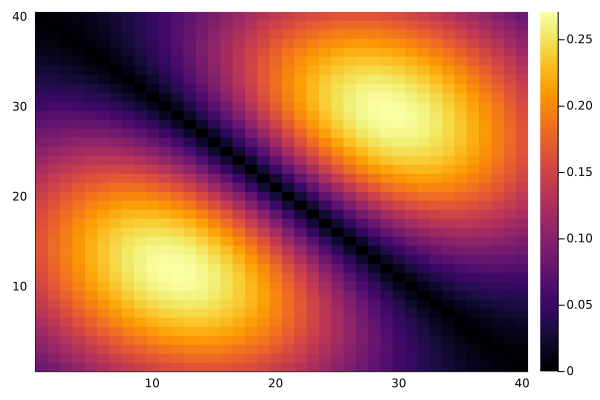

In [15]:
heatmap(Z)

In [16]:
test_batchsize = size(Z)[1]*size(Z)[2]
testsample = zeros(test_batchsize,2)
for ii in 0:test_batchsize-1
    testsample[ii+1,1] = xrange[ii%(size(xrange)[1])+1]
    testsample[ii+1,2] = xrange[div(ii,(size(xrange)[1]))+1]
end;

In [17]:
testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act);

In [18]:
ZZ = reshape(testoutput, size(Z));

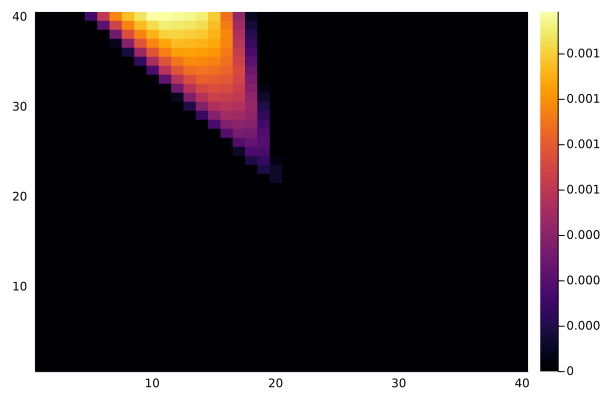

In [19]:
myim = heatmap(ZZ)

In [20]:
function make_batch(batchsize, f)
    inputs = rand(Uniform(-0.5,0.5), batchsize, 2)
    targets = zeros(batchsize,1)
    targets[:, 1] = f.(inputs[:,1],inputs[:,2])
    return(inputs,targets)
end;

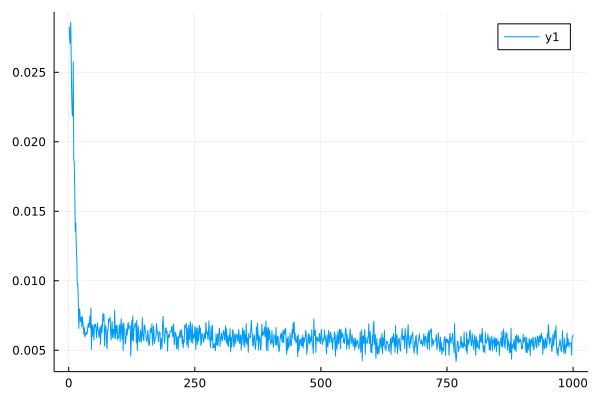

In [21]:
eta = [0.001, 0.1]
batches = 1000
costs = zeros(batches) # array to store the costs

for k in 1:batches
    y_in , y_target = make_batch(batchsize, Func2D)
    costs[k]=train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act, dw_layer, db_layer, batchsize)
end;

plot(costs)

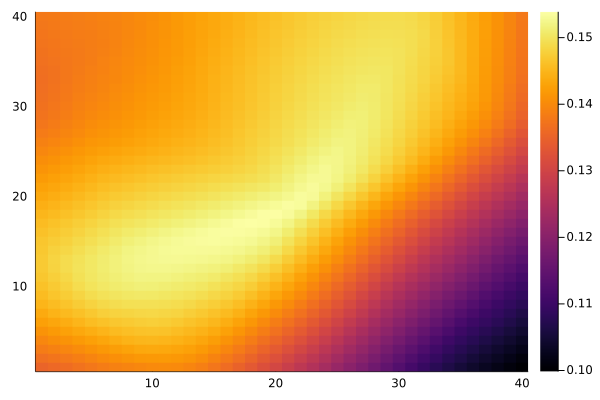

In [22]:
testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act); # check the new network output in the plane 
heatmap(reshape(testoutput, size(Z)))

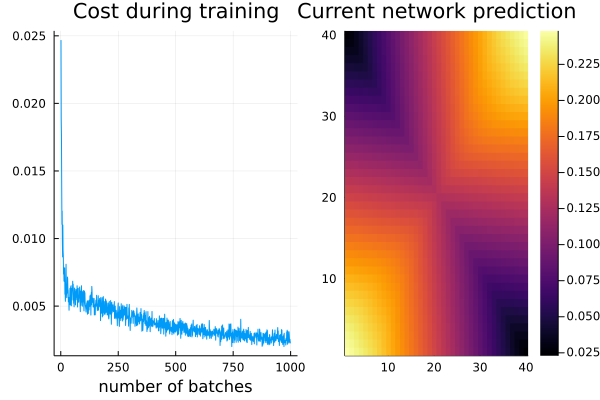

In [23]:
NumLayers = 2 # does not count input-layer (but does count output)
LayerSizes = [2,100,1] # input-layer,hidden layers,output-layer

# initialize random weights and biases for all layers
Weights=[rand(Uniform(-0.1,0.1), LayerSizes[j], LayerSizes[j+1]) for j in 1:NumLayers]
Biases=[zeros(LayerSizes[j+1]) for j in 1:NumLayers]

# define the batchsize
batchsize=100
f_act = ReLU;

# set up all the helper variables

y_layer=[zeros(batchsize,LayerSizes[j]) for j in 1:(NumLayers+1)]
df_layer=[zeros(batchsize,LayerSizes[j+1]) for j in 1:NumLayers]
dw_layer=[zeros(LayerSizes[j],LayerSizes[j+1]) for j in 1:NumLayers]
db_layer=[zeros(LayerSizes[j+1]) for j in 1:NumLayers];


eta = [0.25, 0.1]
batches = 1000
costs = zeros(batches) # array to store the costs

for k in 1:batches
    y_in , y_target = make_batch(batchsize, Func2D)
    costs[k]=train_net(y_in, y_target, eta, Weights, Biases, NumLayers, y_layer, df_layer, f_act, dw_layer, db_layer, batchsize)
    testoutput = apply_net_simple(testsample, Weights, Biases, NumLayers, y_layer, df_layer, f_act); # check the new network output in the plane 
    if k%10 == 0
        IJulia.clear_output(true)
        p2 = heatmap(reshape(testoutput, size(Z)), title="Current network prediction")
        p1 = plot(costs, xlabel ="number of batches", title= "Cost during training")
        display(plot!(p1, p2, layout = (1, 2), legend = false))
    end
    #sleep(0.2)
end;

## References

1. `Michael A. Nielsen. (2015). Neural Networks and Deep Learning. Determination Press.`

5. `F. Marquardt. (2021). Lectures Series of the course: Machine Learning for Physicists.(University of Erlangen-Nuremberg & Max Planck Institute for the Science of Light)`